In [320]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
%matplotlib inline

# read in the json files
transcript = pd.read_csv('data/full_table.csv')

## Summary of the "Data Exploration" Notebook

In the `Data Exploration` notebook the following variables were created:

- **offer_is_completed**: Mark 1 or 0 (True or False) if the received offer were completed in the future.
- **amount_when_completed**: The total spending when the offer is completed starting when the offer is received.

The next two variables are similar to the previous one but show the information on the completed offer row.
- **sum_amount**: Similar to **amount_when_completed**
- **offer_index_received**: Index of the received offer.

Also the **transcript** dataframe is sorted by **person** and **days** in ascending order.

Another extra variables were created:

- **days**: It's a transformation of the time variable to days.
- **offer_id**: Get the offer id from value column.
- **amount**: Get the amount transaction from value column.

In [321]:
col_inspect = ['days', 'event', 'channels','amount', 'reward', 'duration', 'difficulty', 'offer_type', 'offer_is_completed', 'amount_when_completed']
transcript[col_inspect] 

,days,event,channels,amount,reward,duration,difficulty,offer_type,offer_is_completed,amount_when_completed
0,7.00,offer received,"['email', 'mobile', 'social']",NaN,0.0,3.0,0.0,informational,0,0.0
1,8.00,offer viewed,"['email', 'mobile', 'social']",NaN,0.0,3.0,0.0,informational,0,0.0
2,9.50,transaction,NaN,22.16,NaN,NaN,NaN,NaN,0,0.0
3,14.00,offer received,"['web', 'email', 'mobile']",NaN,0.0,4.0,0.0,informational,0,0.0
4,15.50,offer viewed,"['web', 'email', 'mobile']",NaN,0.0,4.0,0.0,informational,0,0.0
...,...,...,...,...,...,...,...,...,...,...
306529,24.00,transaction,NaN,14.23,NaN,NaN,NaN,NaN,0,0.0
306530,24.00,offer completed,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
306531,24.25,offer viewed,"['web', 'email', 'mobile']",NaN,2.0,7.0,10.0,discount,0,0.0
306532,25.25,transaction,NaN,10.12,NaN,NaN,NaN,NaN,0,0.0


## Split data in train and test subset

Text(0.5, 1.0, 'Frequency of how many offers received each customers')

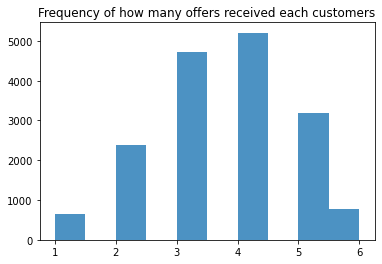

In [485]:
frequency_offer_received_by_person = transcript[(transcript['event'] == 'offer received') & (transcript['offer_type'] != 'informational')].groupby(['person']).count()['event'].values
plt.hist(frequency_offer_received_by_person, alpha=0.8)
plt.title("Frequency of how many offers received each customers")

Most of the customers received 4 or 5 offers. So we are going to select just one offer recieved for each customers. This method avoid any bias for those customers with more offers.

### Selecting just one offer received for each customer

We are  going to create a column `selected for model offer` for each customer to mark if were selected for our model. Then, over this selection we are going to split the data in train and test subsets.

In [323]:
#From the previous notebook we have 17.000 unique customers. So we will expect a similar number.
transcript['selected_for_model_offer'] = 0
sample_person_received = transcript[(transcript['event'] == 'offer received') & (transcript['offer_type'] != 'informational')]\
        .groupby(['person'])\
        .apply(lambda x: x.sample(1, replace = False, random_state=2021))

In [324]:
#How many unique customers with has an 'offer received' and distinct from 'informational'
len(transcript[(transcript['event'] == 'offer received') & (transcript['offer_type'] != 'informational')].person.unique())

16928

In [325]:
# Getting index from sample_person_received
index = [x[1] for x in sample_person_received.index.values]
# Mark this index with 1 as "selected_for_model_offer"
transcript.loc[index, 'selected_for_model_offer'] = 1

n_sel_offers = transcript['selected_for_model_offer'].sum()
n_completed_offers = transcript[transcript['selected_for_model_offer']==1]['offer_is_completed'].sum()
rate_completed = float(n_completed_offers/n_sel_offers)
print('Offers selected for model: ' + str(n_sel_offers))
print('Offers completed from selection: ' + str(n_completed_offers))
print('Rate: ' + "{:.0%}".format(rate_completed))
#col_inspect = ['person','days', 'offer_type', 'offer_is_completed', 'amount_when_completed','selected_for_model_offer']
#transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f'][col_inspect]

Offers selected for model: 16928
Offers completed from selection: 6259
Rate: 37%


### Train and test mark
Since we need already transform some variable in WoE. We need to split in train and test subset previous to this process because this transformation depends on the total of events selected for training the model. So we are going to use again the `sample` function

In [326]:
train_mark = transcript[transcript['selected_for_model_offer'] == 1]\
                    .apply(lambda x: x.sample(frac = 0.8, replace = False, random_state = 2021))
n_sel_offers = train_mark['selected_for_model_offer'].sum()
n_completed_offers = train_mark[train_mark['selected_for_model_offer']==1]['offer_is_completed'].sum()
rate_completed = float(n_completed_offers/n_sel_offers)
print('Train - offer selected for model: ' + str(n_sel_offers))
print('Train - offer completed from selection: ' + str(n_completed_offers))
print('Train - rate: ' + "{:.0%}".format(rate_completed))

Train - offer selected for model: 13542
Train - offer completed from selection: 4998
Train - rate: 37%


In [327]:
#Save Mark on transcript
index_train = [x for x in train_mark.index.values]
index_selected_for_model = [x for x in transcript[transcript['selected_for_model_offer']==1].index.values]
# Mark this index with 1 as "selected_for_model_offer"
transcript['train_test'] = 'None'
transcript.loc[index_selected_for_model, 'train_test'] = 'test'
transcript.loc[index_train, 'train_test'] = 'train'
transcript.groupby(['train_test']).count()['selected_for_model_offer']

train_test
None     289606
test       3386
train     13542
Name: selected_for_model_offer, dtype: int64

## Transforming Data into WoE

In [17]:
import sys
!{sys.executable} -m pip install optbinning

     |████████████████████████████████| 152 kB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 855 kB 40.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 16.8 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 43.7 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 70.7 MB/s eta 0:00:01
     |████████████████████████████████| 164 kB 35.9 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 40.0 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 11.1 MB/s eta 0:00:01
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164803 sha256=129886ab029b1a0a50f56d5ba32e90fafd0c9092be7ea19e90bf44cb608d5de2
  Stored in directory: /Users/alejandrollanos/Library/Caches/pip/wheels/24/6f/0b/da9f81234859a8741aaea3afcc6ae2daf0efb67e7ff2d3686c
  Created wheel for ecos: file

In [30]:
age_list = transcript[transcript['event'] == 'offer received'][['age', 'offer_is_completed']]['age'].values
target = transcript[transcript['event'] == 'offer received'][['age', 'offer_is_completed']]['offer_is_completed'].values

In [31]:
from optbinning import OptimalBinning

## Data Processing

For each variable we are going to applied an Optimal Binning through optbinning library. This method consist in get an optimal discretization for continous and categorical variable given our binary target, offer completed. At the end each  discretization is represented by a number Weight of Evidence (WoE), that show how the category of the bin is related offer completed rate.

The method consist in the following steps ror each continuous or categorical variable :

1. Analyze the discretization given by the optbinning library.
2. Replaced some values if it's necessary to keep the increasing or decreasing tendency of offer completed rate. So if this condition doesn't happen, some treatment can be done over the variables like replace a value. Example: In case of age, some values are above 100 (probably incorrect data), so this values could be replaced for example by -1, to keep the tendency of offer completed rate in an ascending order. But this process can be done only for missing or default in the case of continous variable. In the case of categorical variable any kind of grouping can be done.
3. Create WoE variable.

So with this process, we can have both, WoE data an raw data for our logistic regression model and also the raw data for other kind of models like Neural Network or Decission Trees.

### Age Variable

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

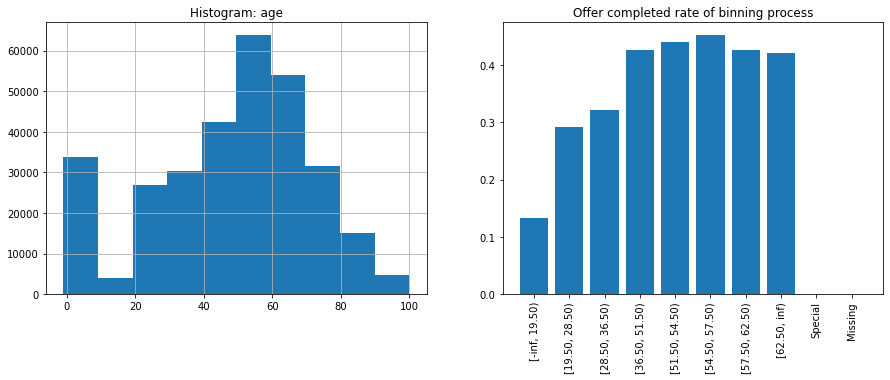

In [515]:
variable = 'age'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
#print(optb.splits)
#print(optb.binning_table.build())
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript['age'].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [516]:
# Change Age values
transcript.loc[transcript['age']>100, 'age'] = -1
# Binning process
var_list = transcript[transcript['event'] == 'offer received'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['event'] == 'offer received'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: age
                   Bin  Count  Count (%)  Event rate       WoE        IV
0         [-inf, 8.50)   9799   0.128466    0.095418   1.45907  0.189198
1        [8.50, 28.50)   6552   0.085897    0.255037  0.281788  0.006437
2       [28.50, 35.50)   4184   0.054853    0.280354  0.152568  0.001239
3       [35.50, 40.50)   4154   0.054459    0.351709 -0.178605  0.001793
4       [40.50, 52.50)  13841   0.181457    0.355682 -0.195986  0.007212
5       [52.50, 72.50)  27895   0.365707    0.359742 -0.213655  0.017323
6       [72.50, 79.50)   4916   0.064449    0.362083 -0.223805  0.003355
7         [79.50, inf)   4936   0.064712    0.370948 -0.261988  0.004644
8              Special      0   0.000000    0.000000         0  0.000000
9              Missing      0   0.000000    0.000000         0  0.000000
Totals                  76277   1.000000    0.312139            0.231201


In [517]:
# Save WoE values to transcript
transcript['age_woe'] = optb.transform(transcript[variable], metric="woe")
#transcript[['age','age_woe']]

### Income Variable

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

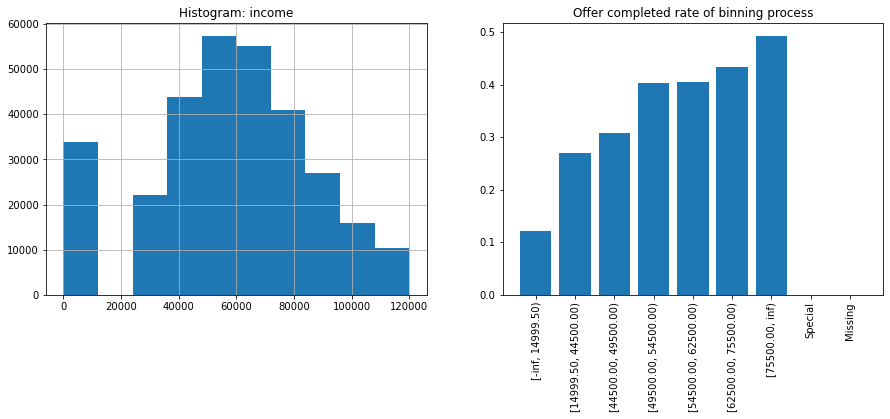

In [461]:
variable = 'income'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [462]:
# Change Age values
transcript.loc[transcript.income.isnull(), 'income'] = -1
var_list = transcript[transcript['event'] == 'offer received'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['event'] == 'offer received'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: income
                         Bin  Count  Count (%)  Event rate       WoE        IV
0           [-inf, 14999.50)   9776   0.128164    0.094722   1.46716  0.190410
1       [14999.50, 43500.00)  12113   0.158803    0.238256  0.372123  0.020335
2       [43500.00, 49500.00)   4854   0.063636    0.265554  0.227158  0.003136
3       [49500.00, 54500.00)   6086   0.079788    0.337003 -0.113461  0.001048
4       [54500.00, 63500.00)  10160   0.133199    0.346850 -0.157227  0.003386
5       [63500.00, 71500.00)   8716   0.114268    0.362552 -0.225833  0.006059
6       [71500.00, 74500.00)   4017   0.052663    0.372417 -0.268279  0.003967
7       [74500.00, 79500.00)   3916   0.051339    0.409091 -0.422415  0.009793
8            [79500.00, inf)  16639   0.218139    0.413186 -0.439329  0.045102
9                    Special      0   0.000000    0.000000         0  0.000000
10                   Missing      0   0.000000    0.000000         0  0.000000
Totals             

In [463]:
# Save WoE values to transcript
transcript['income_woe'] = optb.transform(transcript[variable], metric="woe")
#transcript[['age','age_woe']]

### became_member_on Variable

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

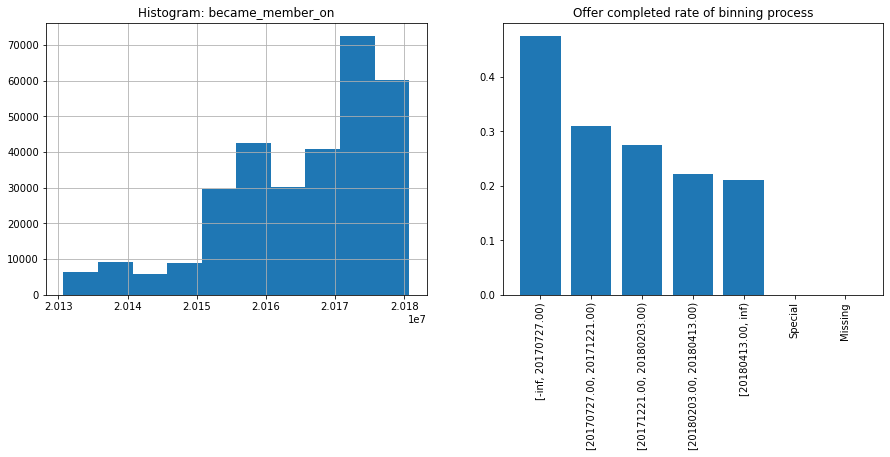

In [464]:
variable = 'became_member_on'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [465]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: became_member_on
                               Bin  Count  Count (%)  Event rate       WoE  \
0              [-inf, 20170727.00)   6607   0.487890    0.475254 -0.437125   
1       [20170727.00, 20171221.00)   3332   0.246049    0.309124  0.268028   
2       [20171221.00, 20180203.00)    901   0.066534    0.275250  0.431957   
3       [20180203.00, 20180413.00)   1072   0.079161    0.221082   0.72318   
4               [20180413.00, inf)   1630   0.120366    0.210429  0.786147   
5                          Special      0   0.000000    0.000000         0   
6                          Missing      0   0.000000    0.000000         0   
Totals                              13542   1.000000    0.369074             

              IV  
0       0.097247  
1       0.016979  
2       0.011580  
3       0.036384  
4       0.064468  
5       0.000000  
6       0.000000  
Totals  0.226657  


In [466]:
# Save WoE values to transcript
transcript['became_member_on_woe'] = optb.transform(transcript[variable], metric="woe")
#transcript[['became_member_on','became_member_on_woe']]

### Gender Variable

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

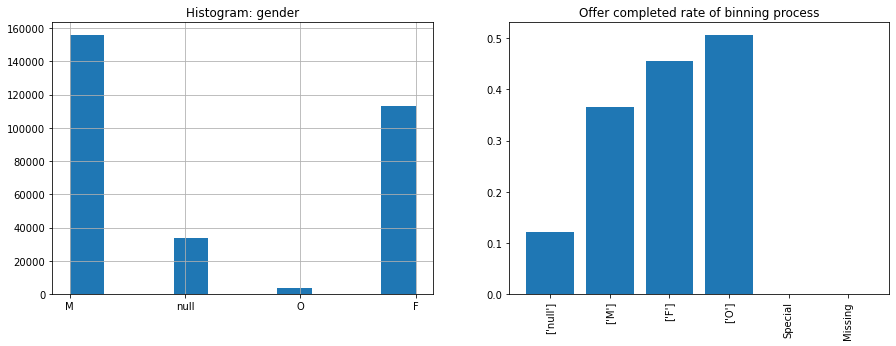

In [467]:
variable = 'gender'
transcript.loc[transcript.gender.isnull(), 'gender'] = 'null'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar([str(x) for x in optb.binning_table.build()['Bin'].values[:-1]], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [468]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: gender
            Bin  Count  Count (%)  Event rate        WoE        IV
0        [null]   1721   0.127086    0.121441    1.44266  0.194975
1           [M]   6752   0.498597    0.365373  0.0159263  0.000126
2           [F]   4891   0.361173    0.456348  -0.361139  0.048886
3           [O]    178   0.013144    0.505618  -0.558664  0.004306
4       Special      0   0.000000    0.000000          0  0.000000
5       Missing      0   0.000000    0.000000          0  0.000000
Totals           13542   1.000000    0.369074             0.248293


In [469]:
# Save WoE values to transcript
transcript['gender_woe'] = optb.transform(transcript[variable], metric="woe")
#transcript.groupby(['gender','gender_woe']).count()['person']

### Reward

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

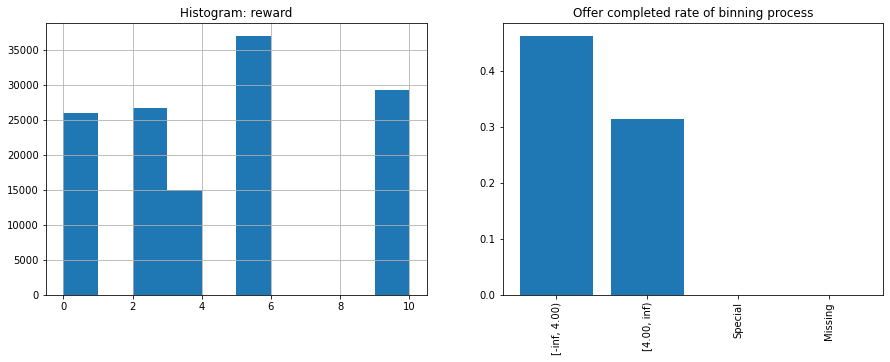

In [470]:
variable = 'reward'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [471]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: reward
                 Bin  Count  Count (%)  Event rate       WoE        IV
0       [-inf, 4.00)   5033   0.371659    0.461752 -0.382902  0.056639
1        [4.00, inf)   8509   0.628341    0.314255  0.244107  0.036109
2            Special      0   0.000000    0.000000         0  0.000000
3            Missing      0   0.000000    0.000000         0  0.000000
Totals                13542   1.000000    0.369074            0.092748


In [472]:
# Save WoE values to transcript
transcript['reward_woe'] = optb.transform(transcript[variable], metric="woe")

### Channels

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

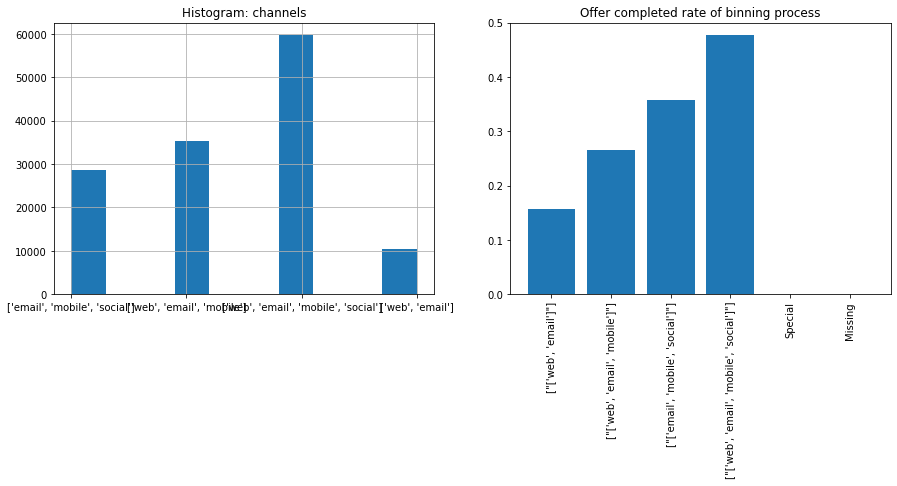

In [473]:
variable = 'channels'
transcript.loc[transcript.gender.isnull(), 'gender'] = 'null'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar([str(x) for x in optb.binning_table.build()['Bin'].values[:-1]], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [474]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: channels
                                           Bin  Count  Count (%)  Event rate  \
0                           [['web', 'email']]   1698   0.125388    0.156655   
1                 [['web', 'email', 'mobile']]   3379   0.249520    0.264871   
2              [['email', 'mobile', 'social']]   1648   0.121695    0.358010   
3       [['web', 'email', 'mobile', 'social']]   6817   0.503397    0.476309   
4                                      Special      0   0.000000    0.000000   
5                                      Missing      0   0.000000    0.000000   
Totals                                          13542   1.000000    0.369074   

              WoE        IV  
0         1.14714  0.131212  
1         0.48461  0.054111  
2       0.0478216  0.000277  
3       -0.441357  0.102317  
4               0  0.000000  
5               0  0.000000  
Totals             0.287916  


In [475]:
transcript['channels_woe'] = optb.transform(transcript[variable], metric="woe")

### Difficulty

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

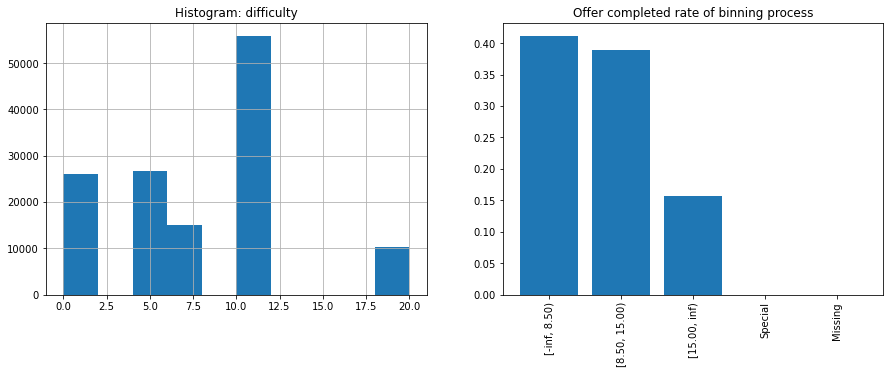

In [476]:
variable = 'difficulty'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [477]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: difficulty
                  Bin  Count  Count (%)  Event rate        WoE        IV
0        [-inf, 8.50)   5168   0.381628    0.411958  -0.180315  0.012673
1       [8.50, 15.00)   6676   0.492985    0.389904 -0.0884762  0.003902
2        [15.00, inf)   1698   0.125388    0.156655    1.14714  0.131212
3             Special      0   0.000000    0.000000          0  0.000000
4             Missing      0   0.000000    0.000000          0  0.000000
Totals                 13542   1.000000    0.369074             0.147787


In [478]:
# Save WoE values to transcript
transcript['difficulty_woe'] = optb.transform(transcript[variable], metric="woe")

### Duration

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

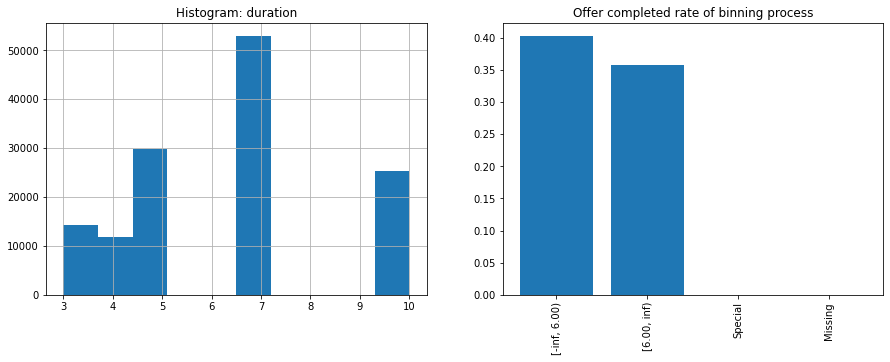

In [486]:
variable = 'duration'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar(optb.binning_table.build()['Bin'].values[:-1], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [487]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: duration
                 Bin  Count  Count (%)  Event rate        WoE        IV
0       [-inf, 6.00)   3422   0.252695    0.402981  -0.143131  0.005267
1        [6.00, inf)  10120   0.747305    0.357609  0.0495668  0.001824
2            Special      0   0.000000    0.000000          0  0.000000
3            Missing      0   0.000000    0.000000          0  0.000000
Totals                13542   1.000000    0.369074             0.007090


In [489]:
#print(variable)
transcript['duration_woe'] = optb.transform(transcript[variable], metric="woe")

In this case the IV is below to 0.02 so the literature said that is not useful for prediction.

### Offer Type

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

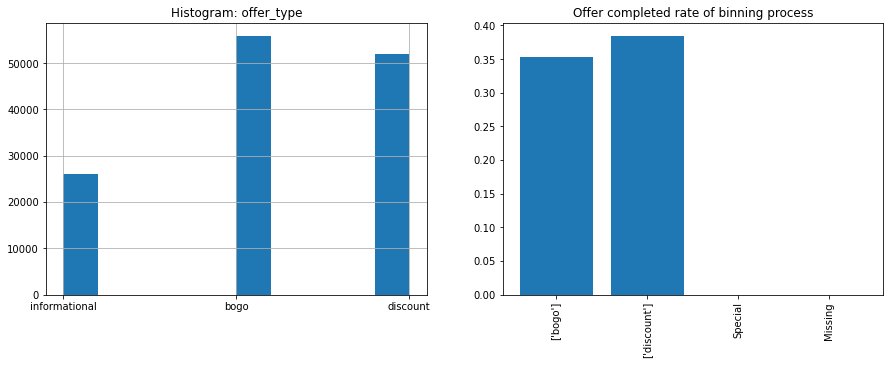

In [490]:
variable = 'offer_type'
transcript.loc[transcript.gender.isnull(), 'gender'] = 'null'
var_list = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']][variable].values
target = transcript[transcript['train_test'] == 'train'][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
fig, axs = plt.subplots(1,2, figsize=(15, 5))
axs[0].set_title('Histogram: ' + variable)
axs[1].set_title('Offer completed rate of binning process')
transcript[variable].hist(ax=axs[0])
plt.bar([str(x) for x in optb.binning_table.build()['Bin'].values[:-1]], optb.binning_table.build()['Event rate'].values[:-1])
plt.xticks(rotation=90)

In [491]:
cols_binning = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
print("Final Group for variable: " + variable)
print(optb.binning_table.build()[cols_binning])

Final Group for variable: offer_type
               Bin  Count  Count (%)  Event rate        WoE        IV
0           [bogo]   6811   0.502954    0.353546  0.0672981  0.002257
1       [discount]   6731   0.497046    0.384787  -0.066912  0.002244
2          Special      0   0.000000    0.000000          0  0.000000
3          Missing      0   0.000000    0.000000          0  0.000000
Totals              13542   1.000000    0.369074             0.004501


In [492]:
transcript['offer_type_woe'] = optb.transform(transcript[variable], metric="woe")

In this case the IV is below to 0.02 so the literature said that is not useful for prediction.

In [493]:
transcript.columns

Index(['Unnamed: 0', 'person', 'event', 'time', 'days', 'offer_id', 'amount',
       'gender', 'age', 'became_member_on', 'income', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type', 'sum_amount',
       'offer_index_received', 'offer_is_completed', 'amount_when_completed',
       'selected_for_model_offer', 'train_test', 'age_woe', 'income_woe',
       'became_member_on_woe', 'gender_woe', 'reward_woe', 'channels_woe',
       'difficulty_woe', 'duration_woe', 'offer_type_woe'],
      dtype='object')

At this point we finished with a total of 5 inputs variable for our logistic regression model.

In [494]:
transcript.to_csv('data/full_table_with_woe.csv')   

## Creating variables by Offer Type - BOGO

In [518]:
condition = (transcript['train_test'] == 'train') & (transcript['offer_type'] == 'bogo')
offer = 'bogo'
#condition = (transcript['train_test'] == 'train') & (transcript['offer_type'] == 'discount')
#offer = 'discount'

### Age

In [519]:
variable = 'age'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        [-inf, 19.50)    939   0.137865        837    102    0.108626   
1       [19.50, 34.50)    796   0.116870        577    219    0.275126   
2       [34.50, 40.50)    393   0.057701        243    150    0.381679   
3       [40.50, 74.50)   3966   0.582293       2342   1624    0.409481   
4         [74.50, inf)    717   0.105271        404    313    0.436541   
5              Special      0   0.000000          0      0    0.000000   
6              Missing      0   0.000000          0      0    0.000000   
Totals                   6811   1.000000       4403   2408    0.353546   

             WoE        IV        JS  
0        1.50136  0.221809  0.025384  
1       0.365281  0.014648  0.001821  
2      -0.121063  0.000860  0.000107  
3      -0.237377  0.033828  0.004219  
4      -0.348278  0.013314  0.001656  
5              0  0.000000  0.000000  
6              0  0.000000  0.000000  
Totals            0.2

In [520]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Income

In [523]:
variable = 'income'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                         Bin  Count  Count (%)  Non-event  Event  Event rate  \
0           [-inf, 14999.50)    853   0.125239        767     86    0.100821   
1       [14999.50, 34500.00)    390   0.057260        304     86    0.220513   
2       [34500.00, 41500.00)    561   0.082367        428    133    0.237077   
3       [41500.00, 48500.00)    496   0.072823        362    134    0.270161   
4       [48500.00, 55500.00)    693   0.101747        429    264    0.380952   
5       [55500.00, 63500.00)    817   0.119953        491    326    0.399021   
6       [63500.00, 71500.00)    774   0.113640        446    328    0.423773   
7       [71500.00, 76500.00)    536   0.078696        301    235    0.438433   
8            [76500.00, inf)   1691   0.248275        875    816    0.482555   
9                    Special      0   0.000000          0      0    0.000000   
10                   Missing      0   0.000000          0      0    0.000000   
Totals                         6811   1.

In [524]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### became_member_on

In [529]:
variable = 'became_member_on'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                               Bin  Count  Count (%)  Non-event  Event  \
0              [-inf, 20170727.00)   3335   0.489649       1826   1509   
1       [20170727.00, 20171105.00)   1141   0.167523        783    358   
2       [20171105.00, 20171221.00)    544   0.079871        384    160   
3       [20171221.00, 20180203.00)    456   0.066951        349    107   
4               [20180203.00, inf)   1335   0.196006       1061    274   
5                          Special      0   0.000000          0      0   
6                          Missing      0   0.000000          0      0   
Totals                               6811   1.000000       4403   2408   

        Event rate       WoE        IV        JS  
0         0.452474 -0.412809  0.087492  0.010860  
1         0.313760   0.17911  0.005223  0.000652  
2         0.294118  0.271979  0.005648  0.000704  
3         0.234649  0.578753  0.020157  0.002485  
4         0.205243  0.750349  0.095433  0.011657  
5         0.000000         

In [530]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Gender

In [533]:
variable = 'gender'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

            Bin  Count  Count (%)  Non-event  Event  Event rate        WoE  \
0        [null]    853   0.125239        767     86    0.100821    1.58465   
1           [M]   3434   0.504184       2282   1152    0.335469  0.0800631   
2           [F]   2437   0.357804       1312   1125    0.461633   -0.44972   
3           [O]     87   0.012773         42     45    0.517241  -0.672482   
4       Special      0   0.000000          0      0    0.000000          0   
5       Missing      0   0.000000          0      0    0.000000          0   
Totals            6811   1.000000       4403   2408    0.353546              

              IV        JS  
0       0.219450  0.024879  
1       0.003193  0.000399  
2       0.076099  0.009433  
3       0.006152  0.000755  
4       0.000000  0.000000  
5       0.000000  0.000000  
Totals  0.304894  0.035466  


In [534]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Rewards

In [537]:
variable = 'reward'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [-inf, 7.50)   3430   0.503597       2228   1202    0.350437   
1        [7.50, inf)   3381   0.496403       2175   1206    0.356699   
2            Special      0   0.000000          0      0    0.000000   
3            Missing      0   0.000000          0      0    0.000000   
Totals                 6811   1.000000       4403   2408    0.353546   

              WoE        IV        JS  
0       0.0136279  0.000093  0.000012  
1        -0.01377  0.000094  0.000012  
2               0  0.000000  0.000000  
3               0  0.000000  0.000000  
Totals             0.000188  0.000023  


### Channels

In [538]:
variable = 'channels'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                                           Bin  Count  Count (%)  Non-event  \
0                 [['web', 'email', 'mobile']]   1741   0.255616       1302   
1              [['email', 'mobile', 'social']]   1648   0.241962       1058   
2       [['web', 'email', 'mobile', 'social']]   3422   0.502423       2043   
3                                      Special      0   0.000000          0   
4                                      Missing      0   0.000000          0   
Totals                                           6811   1.000000       4403   

        Event  Event rate        WoE        IV        JS  
0         439    0.252154   0.483668  0.054847  0.006790  
1         590    0.358010 -0.0194765  0.000092  0.000012  
2        1379    0.402981  -0.210429  0.022868  0.002853  
3           0    0.000000          0  0.000000  0.000000  
4           0    0.000000          0  0.000000  0.000000  
Totals   2408    0.353546             0.077807  0.009655  


In [539]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Difficulty

In [540]:
variable = 'difficulty'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [-inf, 7.50)   3430   0.503597       2228   1202    0.350437   
1        [7.50, inf)   3381   0.496403       2175   1206    0.356699   
2            Special      0   0.000000          0      0    0.000000   
3            Missing      0   0.000000          0      0    0.000000   
Totals                 6811   1.000000       4403   2408    0.353546   

              WoE        IV        JS  
0       0.0136279  0.000093  0.000012  
1        -0.01377  0.000094  0.000012  
2               0  0.000000  0.000000  
3               0  0.000000  0.000000  
Totals             0.000188  0.000023  


### Duration

In [541]:
variable = 'duration'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [-inf, 6.00)   3422   0.502423       2043   1379    0.402981   
1        [6.00, inf)   3389   0.497577       2360   1029    0.303629   
2            Special      0   0.000000          0      0    0.000000   
3            Missing      0   0.000000          0      0    0.000000   
Totals                 6811   1.000000       4403   2408    0.353546   

             WoE        IV        JS  
0      -0.210429  0.022868  0.002853  
1       0.226585  0.024624  0.003071  
2              0  0.000000  0.000000  
3              0  0.000000  0.000000  
Totals            0.047491  0.005925  


In [542]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

## Creating variables by Offer Type - Discount

In [558]:
condition = (transcript['train_test'] == 'train') & (transcript['offer_type'] == 'discount')
offer = 'discount'

### Age

In [559]:
variable = 'age'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                   Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        [-inf, 22.50)   1121   0.166543        930    191    0.170384   
1       [22.50, 29.50)    395   0.058684        270    125    0.316456   
2       [29.50, 36.50)    393   0.058387        249    144    0.366412   
3       [36.50, 52.50)   1503   0.223295        850    653    0.434464   
4       [52.50, 56.50)    577   0.085723        322    255    0.441941   
5       [56.50, 74.50)   2018   0.299807       1125    893    0.442517   
6       [74.50, 81.50)    382   0.056752        209    173    0.452880   
7         [81.50, inf)    342   0.050810        186    156    0.456140   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                   6731   1.000000       4141   2590    0.384787   

              WoE        IV        JS  
0         1.11363  0.167978  0.019975  
1        0.300829  0.005096  0.

In [560]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")
#print(name)

### Income

In [561]:
variable = 'income'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="ascending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                         Bin  Count  Count (%)  Non-event  Event  Event rate  \
0           [-inf, 14999.50)    868   0.128956        745    123    0.141705   
1       [14999.50, 44500.00)   1112   0.165206        771    341    0.306655   
2       [44500.00, 49500.00)    361   0.053632        244    117    0.324100   
3       [49500.00, 62500.00)   1364   0.202644        797    567    0.415689   
4       [62500.00, 75500.00)   1306   0.194028        732    574    0.439510   
5            [75500.00, inf)   1720   0.255534        852    868    0.504651   
6                    Special      0   0.000000          0      0    0.000000   
7                    Missing      0   0.000000          0      0    0.000000   
Totals                         6731   1.000000       4141   2590    0.384787   

             WoE        IV        JS  
0        1.33192  0.176370  0.020549  
1       0.346526  0.018895  0.002350  
2       0.265715  0.003653  0.000455  
3      -0.128784  0.003407  0.000426  
4   

In [562]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### became_member_on

In [563]:
variable = 'became_member_on'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb.fit(var_list, target)
print(optb.binning_table.build())

                               Bin  Count  Count (%)  Non-event  Event  \
0              [-inf, 20160701.00)   1840   0.273362        919    921   
1       [20160701.00, 20170401.00)    999   0.148418        500    499   
2       [20170401.00, 20170727.00)    433   0.064329        222    211   
3       [20170727.00, 20180203.00)   2092   0.310801       1439    653   
4       [20180203.00, 20180413.00)    544   0.080820        408    136   
5               [20180413.00, inf)    823   0.122270        653    170   
6                          Special      0   0.000000          0      0   
7                          Missing      0   0.000000          0      0   
Totals                               6731   1.000000       4141   2590   

        Event rate       WoE        IV        JS  
0         0.500543 -0.471453  0.063020  0.007805  
1         0.499499 -0.467277  0.033607  0.004163  
2         0.487298  -0.41846  0.011657  0.001447  
3         0.312141  0.320847  0.030601  0.003809  
4   

In [564]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Gender

In [565]:
variable = 'gender'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

            Bin  Count  Count (%)  Non-event  Event  Event rate       WoE  \
0        [null]    868   0.128956        745    123    0.141705   1.33192   
1           [M]   3318   0.492943       2003   1315    0.396323  -0.04847   
2           [F]   2454   0.364582       1347   1107    0.451100 -0.273053   
3           [O]     91   0.013520         46     45    0.494505 -0.447301   
4       Special      0   0.000000          0      0    0.000000         0   
5       Missing      0   0.000000          0      0    0.000000         0   
Totals            6731   1.000000       4141   2590    0.384787             

              IV        JS  
0       0.176370  0.020549  
1       0.001164  0.000146  
2       0.027887  0.003475  
3       0.002803  0.000347  
4       0.000000  0.000000  
5       0.000000  0.000000  
Totals  0.208224  0.024517  


In [566]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Rewards

In [567]:
variable = 'reward'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                 Bin  Count  Count (%)  Non-event  Event  Event rate      WoE  \
0       [-inf, 4.00)   5033   0.747734       2709   2324    0.461752 -0.31599   
1        [4.00, inf)   1698   0.252266       1432    266    0.156655  1.21405   
2            Special      0   0.000000          0      0    0.000000        0   
3            Missing      0   0.000000          0      0    0.000000        0   
Totals                 6731   1.000000       4141   2590    0.384787            

              IV        JS  
0       0.076819  0.009563  
1       0.295145  0.034782  
2       0.000000  0.000000  
3       0.000000  0.000000  
Totals  0.371965  0.044345  


### Channels

In [568]:
variable = 'channels'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                                           Bin  Count  Count (%)  Non-event  \
0                           [['web', 'email']]   1698   0.252266       1432   
1                 [['web', 'email', 'mobile']]   1638   0.243352       1182   
2       [['web', 'email', 'mobile', 'social']]   3395   0.504383       1527   
3                                      Special      0   0.000000          0   
4                                      Missing      0   0.000000          0   
Totals                                           6731   1.000000       4141   

        Event  Event rate       WoE        IV        JS  
0         266    0.156655   1.21405  0.295145  0.034782  
1         456    0.278388  0.483191  0.052850  0.006543  
2        1868    0.550221 -0.670843  0.236461  0.029016  
3           0    0.000000         0  0.000000  0.000000  
4           0    0.000000         0  0.000000  0.000000  
Totals   2590    0.384787            0.584456  0.070341  


In [569]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

### Difficulty

In [570]:
variable = 'difficulty'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                  Bin  Count  Count (%)  Non-event  Event  Event rate  \
0        [-inf, 8.50)   1738   0.258208        811    927    0.533372   
1       [8.50, 15.00)   3295   0.489526       1898   1397    0.423976   
2        [15.00, inf)   1698   0.252266       1432    266    0.156655   
3             Special      0   0.000000          0      0    0.000000   
4             Missing      0   0.000000          0      0    0.000000   
Totals                  6731   1.000000       4141   2590    0.384787   

             WoE        IV        JS  
0      -0.602965  0.097722  0.012033  
1      -0.162806  0.013194  0.001647  
2        1.21405  0.295145  0.034782  
3              0  0.000000  0.000000  
4              0  0.000000  0.000000  
Totals            0.406060  0.048463  


### Duration

In [571]:
variable = 'duration'
var_list = transcript[condition][[variable, 'offer_is_completed']][variable].values
target = transcript[condition][[variable, 'offer_is_completed']]['offer_is_completed'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
#optb = OptimalBinning(name=variable, dtype="numerical", solver="cp", monotonic_trend="descending")
#optb = OptimalBinning(name=variable, dtype="categorical", solver="mip",cat_cutoff=0.1)
optb.fit(var_list, target)
print(optb.binning_table.build())

                 Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       [-inf, 8.50)   3376    0.50156       1993   1383    0.409656   
1        [8.50, inf)   3355    0.49844       2148   1207    0.359762   
2            Special      0    0.00000          0      0    0.000000   
3            Missing      0    0.00000          0      0    0.000000   
Totals                 6731    1.00000       4141   2590    0.384787   

             WoE        IV        JS  
0      -0.103893  0.005474  0.000684  
1        0.10712  0.005644  0.000705  
2              0  0.000000  0.000000  
3              0  0.000000  0.000000  
Totals            0.011119  0.001389  


In [572]:
name = variable+'_'+offer+'_woe'
transcript[name] = optb.transform(transcript[variable], metric="woe")

In [573]:
transcript.to_csv('data/full_table_with_woe.csv')   

In [574]:
amount_difference = []
for index, row in transcript[transcript['amount_when_completed']>0][col_inspect].iterrows():
    #print(row['sum_amount'], transcript.at[row['offer_index_completed'], 'difficulty'])
    diff_amount = row['amount_when_completed'] - row['difficulty']
    if diff_amount < 0 or np.isnan(diff_amount): print(transcript.at[index, 'person'])
    amount_difference.append(diff_amount)
amount_difference = sorted(amount_difference)
print(min(amount_difference), print(max(amount_difference)))

1005.73
0.0 None


In [577]:
transcript[transcript['amount_when_completed']>0]['amount_when_completed'] - transcript[transcript['amount_when_completed']>0]['difficulty']

5         17.68
9         27.94
30         4.93
36         2.05
38        17.05
          ...  
306501     6.06
306507     2.88
306515     5.57
306519     7.55
306524    17.02
Length: 23809, dtype: float64